In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors
from sklearn.model_selection import train_test_split
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
from keras.layers.core import Dense, Activation, Dropout
import keras
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
import time
from numpy import newaxis
import warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as mse

Using TensorFlow backend.


In [21]:
def normalise_windows(window_data):
    normalised_data = []
    normalised_window_0 = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
        normalised_window_0.append(window[0])
    return (normalised_data,normalised_window_0)
#divides each value 

In [3]:
def reverse_normalise(y, reverse, start_val):
    normalised_data = []
    i = start_val
    for valuey in y:
        value = ((float(valuey)+1) * float(reverse[i])) 
        normalised_data.append(value)
        i = i+1
    return normalised_data

In [4]:
def set_data(stock, seq_len):
        raw_seq = pd.read_csv("../Stock_CSV/"+ stock +'.csv')['4. close']
        sequence_length = seq_len + 1
        seq = [ele for ele in reversed(raw_seq)] 
        seq = np.array(seq)
        result = []
        for index in range(len(seq) - sequence_length ):
            result.append(seq[index: index + sequence_length])
        
        result, result_reverse = normalise_windows(result)
        
        result = np.array(result)

        row = round(0.95 * len(result))
        train = result[:int(row), :]
        x_train = train[:, :-1]
        y_train = train[:, -1]
        x_test = result[int(row):, :-1]
        y_test = result[int(row):, -1]

        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

        result.shape
        return (x_train, x_test, y_train, y_test, result_reverse, row)
    #except:
        #print("file" + stock + ".csv not found")


In [5]:
def get_test_data(ticker, seq_len):
        raw_seq = pd.read_csv("../Stock_CSV/"+ ticker +'.csv')['4. close']
        sequence_length = seq_len + 1
        seq = [ele for ele in reversed(raw_seq)] 
        seq = np.array(seq)
        result = []
        for index in range(len(seq) - sequence_length):
            result.append(seq[index: index + sequence_length])
    
        result = normalise_windows(result)
        result = np.array(result)

        row = round(0.95 * len(result))
        train = result[:int(row), :]
        np.random.shuffle(train)
        x_test = result[int(row):, :-1]
        y_test = result[int(row):, -1]

        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

        return (x_test, y_test)


    

In [6]:
def set_stock_list():
    arr = []
    with open("../NASDAQ.txt", "r") as filestream:
        for line in filestream:
            currentline = line.split(',')
            arr.append(currentline)
    newarr = np.array(arr[0])
    return newarr

In [7]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [8]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted


In [9]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs


In [10]:
def plot_results_multiple(predicted_data, true_data, prediction_len, stock):
    fig = plt.figure(facecolor='white',figsize = (14,4))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data)
        plt.title(stock + " Closing Stock Price")
        plt.legend()
    plt.show()

In [11]:
from keras.models import load_model
#model.save('stock_NN.h5')

In [115]:
def accuracy(y_true, y_pred):
    prev_true = y_true[0]
    prev_pred = y_pred[0]
    correct = 0
    incorrect = 0
    for i in range(1,len(predicted)):
        if prev_true < y_true[i] and prev_true < y_pred[i]:
            correct = correct+1
        elif prev_true > y_true[i] and prev_true > y_pred[i]:
            correct = correct+1
        else:
            incorrect = incorrect+1
        prev_true = y_true[i]
        prev_pred = y_pred[i]        
    return (correct, incorrect)

In [531]:
def build_model(shape):
    #act = keras.layers.advanced_activations.PReLU(init='zero', weights=None)
    # The LSTM architecture
    regressor = Sequential()
    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=50, return_sequences=True, input_shape=(shape,1)))
    regressor.add(Dropout(0.4))
    # Second LSTM layer
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.4))
    # Third LSTM layer
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.5))
    #model.add(Activation('sigmoid'))
    # Fourth LSTM layer 
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.5))
    # The output layer
   
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer='adam', loss='mean_squared_error')
    return regressor

In [775]:
seq_length = 300

In [776]:
model = build_model(seq_length)

In [777]:
stock_list = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT']

In [778]:
stock_list = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT','AAPL','ABT','ACN','ADBE','AGN','AIG','ALL','AMGN','AXP','BA','BAC','BIIB','BK','BKNG',
                'BLK','BMY','BRK.B','C','CAT','CL','CMCSA','COF','COST','CVS','CVX','DD','DHR','DIS',
                'DUK','EMR','EXC','F','FB','FDX','GD','GE','GILD','GM','GOOG','GS','HD','HON',
                'INTC','JNJ','JPM','KHC','KMI','KO','LLY','LMT','LOW','MA','MCD','MDLZ','MDT','MET','MMM','MO','MRK',
                'MS','NEE','NFLX','NKE','ORCL','OXY','PEP','PFE','PG','PM','PYPL','QCOM','RTN','SBUX','SLB',
              'SO','SPG','T','TGT','TMO','TXN','UNH','UNP','UPS','USB','UTX','V','VZ','WBA','WFC','XOM']

In [ ]:
epochs = 2
#stock_list = set_stock_list()
for stock in stock_list:
    print(stock)
    try:
        x_train,x_test,y_train,y_test, reverse, row = set_data(stock , seq_length)
        hist = model.fit(
                x_train,
                y_train,
                batch_size = 256,
                nb_epoch=epochs,
                validation_data=(x_test, y_test))
    except:
        print("not found")



AMZN
Train on 4494 samples, validate on 237 samples
Epoch 1/2
4494/4494 [==============================] - 12s 3ms/step - loss: 0.1996 - val_loss: 0.0042
Epoch 2/2
4494/4494 [==============================] - 10s 2ms/step - loss: 0.0579 - val_loss: 0.0054
MSFT
Train on 4494 samples, validate on 237 samples
Epoch 1/2
4494/4494 [==============================] - 10s 2ms/step - loss: 0.0072 - val_loss: 0.0095
Epoch 2/2
4494/4494 [==============================] - 10s 2ms/step - loss: 0.0061 - val_loss: 0.0089
GOOGL
Train on 3448 samples, validate on 182 samples
Epoch 1/2
3448/3448 [==============================] - 8s 2ms/step - loss: 0.0199 - val_loss: 0.0062
Epoch 2/2
3448/3448 [==============================] - 8s 2ms/step - loss: 0.0175 - val_loss: 0.0058
CTSH
Train on 4494 samples, validate on 237 samples
Epoch 1/2
4494/4494 [==============================] - 10s 2ms/step - loss: 0.0243 - val_loss: 0.0057
Epoch 2/2
4494/4494 [==============================] - 10s 2ms/step - loss: 0.0

4495/4495 [==============================] - 11s 2ms/step - loss: 0.0069 - val_loss: 0.0015
CVX
not found
DD
not found
DHR
Train on 4495 samples, validate on 237 samples
Epoch 1/2
4495/4495 [==============================] - 11s 2ms/step - loss: 0.0058 - val_loss: 0.0023
Epoch 2/2
4495/4495 [==============================] - 10s 2ms/step - loss: 0.0057 - val_loss: 0.0022
DIS
Train on 4495 samples, validate on 237 samples
Epoch 1/2
4495/4495 [==============================] - 10s 2ms/step - loss: 0.0057 - val_loss: 0.0034
Epoch 2/2
4495/4495 [==============================] - 11s 2ms/step - loss: 0.0055 - val_loss: 0.0034
DUK
Train on 4495 samples, validate on 237 samples
Epoch 1/2
4495/4495 [==============================] - 10s 2ms/step - loss: 0.0294 - val_loss: 0.0026
Epoch 2/2
4495/4495 [==============================] - 11s 2ms/step - loss: 0.0287 - val_loss: 0.0021
EMR
not found
EXC
Train on 4494 samples, validate on 237 samples
Epoch 1/2
4494/4494 [==============================

In [ ]:
x_train, x_test, y_train,y_test, for_reverse, row = set_data('TCCO',seq_length)
y_test_graph = reverse_normalise(y_test, for_reverse, row)

In [ ]:
predicted = predict_point_by_point(model, x_test)
predicted_graph = reverse_normalise(predicted, for_reverse, row)
mse(y_test,predicted)

In [ ]:
plt.plot(y_test[150:])
plt.plot(predicted[150:])


In [ ]:
correct , incorrect= accuracy(y_test, predicted)
print("number correct:", correct)
print("number incorrect", incorrect)
print("percetage correct:", float(correct/(correct+incorrect)))

In [ ]:
predictions = predict_sequences_multiple(model, x_test, seq_length,10)
plot_results_multiple(predictions, y_test, 10, 'TCCO') 

In [ ]:
best = 0.0000001
average = 0

In [ ]:
#10 works best
for stock in stock_list:
    try:
        x_train,x_test,y_train,y_test, for_reverse, row = set_data(stock , seq_length)
        predicted = predict_point_by_point(model, x_test)
        y_test_graph = reverse_normalise(y_test, for_reverse, row)
        predicted_graph = reverse_normalise(predicted, for_reverse, row)
        plt.plot(y_test[150:])
        plt.plot(predicted[150:])
        plt.title(stock + " Closing Stock Price day to day")
        plt.show()
        correct , incorrect = accuracy(y_test, predicted)
        print(stock, " number correct:", correct)
        print(stock," number incorrect", incorrect)
        print(stock," percetage correct:", float(correct/(correct+incorrect)))
        average = average + float(correct/(correct+incorrect))
        if float(correct/(correct+incorrect)) > best:
            best = float(correct/(correct+incorrect))
            best_stock = stock
    except:
        print("not found")
print("best stock:",best_stock)
print("score: ",best)
print("average: ", float(average/(len(stock_list))))

In [ ]:
stock_list = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT']

In [ ]:
for stock in stock_list:
    x_train,x_test,y_train,y_test, result, row = set_data(stock , seq_length)
    predictions = predict_sequences_multiple(model, x_test, seq_length,7)
    plot_results_multiple(predictions, y_test, 7, stock) 

In [761]:
model.save('stock_nn_'+ str(epochs)+'epochs_'+str(seq_length)+'best2.h5')

In [743]:
model = load_model('stock_nn_1epochs_200best.h5')

In [692]:
def predict_future(stock, days, model):
        x_train,x_test,y_train,y_test, for_reverse, row = set_data(stock , seq_length)
        prev_predicted = predict_point_by_point(model, x_test)
        new = x_test[-1][1:]
        new = np.append(new, y_test[-1])
        new = new.reshape(1,-1,1)
        newPredicted = model.predict(new)
        prev_predicted = np.append(prev_predicted,newPredicted)
        for i in range(2,days+1):
            new = x_test[-1][i:]
            new = np.append(new, prev_predicted[len(prev_predicted)-i:])
            new = new.reshape(1,-1,1)
            newPredicted = model.predict(new)
            prev_predicted = np.append(prev_predicted,newPredicted)
        return (y_test, prev_predicted)

In [693]:
days = 7

In [741]:
y_test , predicted = predict_future('IBM', days, model)

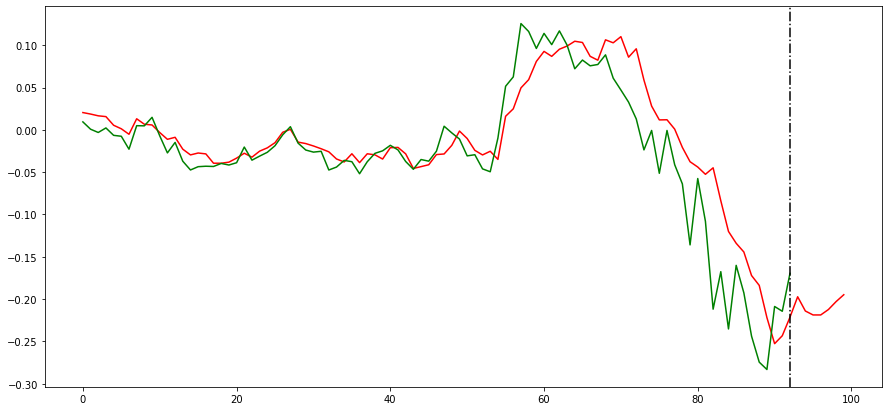

In [742]:
plt.figure(figsize = (15,7))
plt.plot(predicted[len(predicted)-100:], color = 'red')
plt.plot(y_test[len(y_test)-100+days:], color = 'g')
plt.axvline(100-days-1, 0, 1, linestyle = '-.' , color ='black')

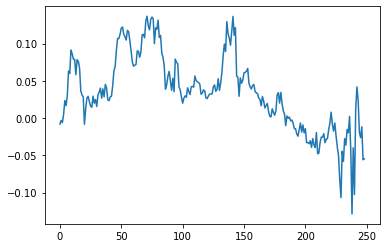